# MODNet - Portrait Image Matting Demo

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/pdf/2011.11961.pdf)          [![GitHub stars](https://img.shields.io/github/stars/ZHKKKe/MODNet?style=social)](https://github.com/ZHKKKe/MODNet)

<p align="justify">This is a <b>Portrait Image Matting Demo</b> of our paper ''<a href="https://arxiv.org/pdf/2011.11961.pdf">Is a Green Screen Really Necessary for Real-Time Portrait Matting?</a>''. We propose a trimap-free MODNet for portrait matting in real time (on a single GPU). If you want to try portrait video matting with MODNet, please refer to our <b>Real-Time Portrait Video Matting Demo</b> based on WebCam [<a href="https://colab.research.google.com/drive/1Pt3KDSc2q7WxFvekCnCLD8P0gBEbxm6J?usp=sharing">online demo</a>] [<a href="https://github.com/ZHKKKe/MODNet/tree/master/demo/video_matting">offline demo</a>].</p>

<img src="https://raw.githubusercontent.com/ZHKKKe/MODNet/develop/doc/gif/image_matting_demo.gif" width="40%">

<p align="justify">In this demo, we provide a pre-trained MODNet for photographic portrait images (<i>e.g.</i>, the image from <a href="https://www.flickr.com/">Flickr</a>). Of course, this model can also handle the portrait images from other data domains (<i>e.g.</i>, the image captured by smartphone). Note that <b><font color='#FF000'>our model may still fail in some cases (<i>e.g.</i>, complex backgrounds and challenging poses/costumes) due to our relatively small labeled training set (only 3k labeled foregrounds)</font></b>.</p>

### **Let's start!**

# Resizing

In [80]:
# 최종 버전!  PIL로 resize하기 꽉 채워서

import os,sys
from PIL import Image
import numpy as np
import cv2

size = 192, 256 #바꾸고 싶은 사이즈
# path = "/content/original/model" #이미지 경로
# modified_path = "/content/resized/model" #resize된 이미지가 저장될 경로

path = "/content/original/clothes" #이미지 경로
modified_path = "/content/resized/clothes" #resize된 이미지가 저장될 경로
os.chdir(path)



def resize_and_crop(img_path, modified_path, size, crop_type='middle'):
    
    files = os.listdir(img_path)
    files = [i for i in files if i != '.ipynb_checkpoints']
    print(files)
    for file in files: 
        
        name = str(file)
        os.chdir(img_path)
        img = Image.open(file)
        img_ratio = img.size[0] / float(img.size[1])
        ratio = size[0] / float(size[1])
        
        if ratio > img_ratio:
            img = img.resize((size[0], int(round(size[0] * img.size[1] / img.size[0]))),
                Image.ANTIALIAS)     
            if crop_type == 'top':
                box = (0, 0, img.size[0], size[1])
            elif crop_type == 'middle':
                box = (0, int(round((img.size[1] - size[1]) / 2)), img.size[0],
                    int(round((img.size[1] + size[1]) / 2)))
            elif crop_type == 'bottom':
                box = (0, img.size[1] - size[1], img.size[0], img.size[1])
            else :
                raise ValueError('ERROR: invalid value for crop_type')
            img = img.crop(box)
            
        elif ratio < img_ratio:
            img = img.resize((int(round(size[1] * img.size[0] / img.size[1])), size[1]),
                Image.ANTIALIAS)
            if crop_type == 'top':
                box = (0, 0, size[0], img.size[1])
            elif crop_type == 'middle':
                box = (int(round((img.size[0] - size[0]) / 2)), 0,
                    int(round((img.size[0] + size[0]) / 2)), img.size[1])
            elif crop_type == 'bottom':
                box = (img.size[0] - size[0], 0, img.size[0], img.size[1])
            else :
                raise ValueError('ERROR: invalid value for crop_type')
            img = img.crop(box)
            
        else :
            img = img.resize((size[0], size[1]), Image.ANTIALIAS)
            
        os.chdir(modified_path)
        img.save(name)
        # img.save(name+'.jpg')

resize_and_crop(path, modified_path, size)


['바지.jpg', '바지.png', 'blue맨투맨.jpg', '블라우스.jpg']


## 1. Preparation

<p align="justify">In the top menu of this session, select <b>Runtime -> Change runtime type</b>, and set <b>Hardware Accelerator</b> to <b>GPU</b>.</p>

<p align="justify">Clone the repository, and download the pre-trained model:</p>


In [90]:
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1mcr7ALciuAsHCpLnrtG_eop5-EYhbCmz \
          -O pretrained/modnet_photographic_portrait_matting.ckpt


/content
/content/MODNet


## 2. Upload Images

<p align="justify">Upload portrait images to be processed (only PNG and JPG format are supported):</p>

In [35]:
os.listdir('/content/resized/model')

['통통모델3.jpg', '통통모델4.jpg', '남성모델.jpg', '통통모델2.jpg', '통통모델.jpg', '통통모델1.jpg']

In [96]:
import shutil
from google.colab import files

# clean and rebuild the image folders
input_folder = 'demo/image_matting/colab/input'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

output_folder = 'demo/image_matting/colab/output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)

# upload images (PNG or JPG)
image_names = list(files.upload().keys())
# image_names = os.listdir('/content/resized/model')
print('image_names :', image_names)
for image_name in image_names:
  shutil.move(image_name, os.path.join(input_folder, image_name))


Saving gucci.jpg to gucci.jpg
image_names : ['gucci.jpg']


In [97]:
image_names

['gucci.jpg']

## 3. Inference

<p align="justify">Run the following command for alpha matte prediction:</p>

In [98]:
!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt


Process image: gucci.jpg
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


## 4. Visualization

<p align="justify">Display the results (from left to right: image, foreground, and alpha matte):</p>

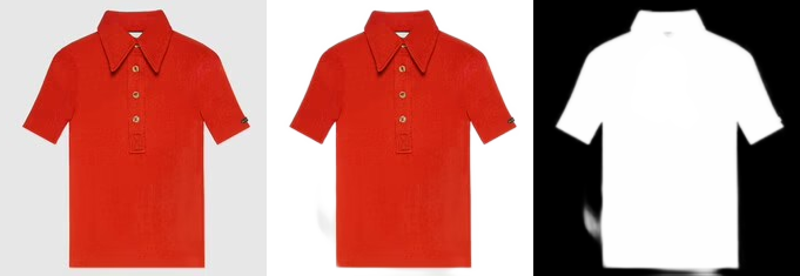

gucci.jpg 



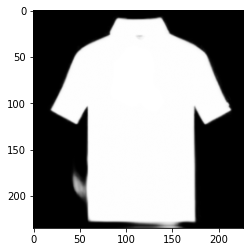

In [99]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  foreground = Image.fromarray(np.uint8(foreground))
  plt.imshow(matte)
  # matte.save('testpants.jpg')
  return combined

# visualize all images
image_names = os.listdir(input_folder)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(input_folder, image_name))
  matte = Image.open(os.path.join(output_folder, matte_name))
  display(combined_display(image, matte))
  print(image_name, '\n')


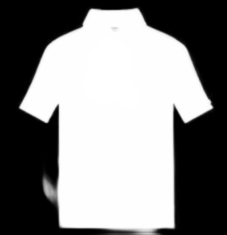

In [100]:
matte

## Download Results

<p align="justify">Download the Zip package of predicted alpha mattes:</p>

In [ ]:
zip_filename = 'matte.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)

os.system(f"zip -r -j {zip_filename} {output_folder}/*")
files.download(zip_filename)